In [ ]:
# !pip install mvlearn==0.5.0 wordcloud==1.9.3 matplotlib==3.3.4 distinctipy==1.3.4 networkx==3.2.1  umap==0.1.1 hoggorm==0.13.3 adilsm==0.0.11 scikit-learn==1.1.2 scipy==1.9.1 numpy==1.23.3
# scipy==1.9.1 used (due to changes in SVDS in later versions) to reproduce presented results in ref paper
# scikit-learn==1.1.2 used (due to changes in MDS in later versions) to reproduce presented results in ref paper
# numpy==1.23.3 used (due to changes in ??? in later versions) to reproduce presented results in ref paper

In [ ]:
# !pip install -e ..
# !pip list

In [1]:
# !pip install --upgrade torch==1.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
# !pip install mowgli

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import distinctipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.preprocessing import normalize
from mvlearn.datasets import load_UCImultifeature

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.decomposition
import umap

import adilsm.adilsm as ilsm
import muon as mu

import torch
from torchnmf.nmf import NMF
from mowgli import models
from mofapy2.run.entry_point import entry_point
from ism_utils import specificity_score, specificity_plot

RESULTS_PATH = './results/'
DATA_PATH = './data/'

torch.cuda.is_available()

adilsm version=0.0.12


True

In [2]:
# Load the data for ism
import scipy.io
mat = scipy.io.loadmat(DATA_PATH+'prokaryotic.mat')
Xs = [mat["text"], -mat["text"], mat["proteome_comp"], -mat["proteome_comp"], mat["gene_repert"], -mat["gene_repert"]]
list_cell_codes = np.array(mat["truth"].flatten().tolist()) - 1
score_pref = ['text+', 'text-', 'proteome_comp+', 'proteome_comp-' 'gene_repert+', 'gene_repert-']


In [4]:
# Load the data for mofa
import scipy.io
mat = scipy.io.loadmat(DATA_PATH+'prokaryotic.mat')
Xs = [mat["text"], mat["proteome_comp"], mat["gene_repert"]]
list_cell_codes = np.array(mat["truth"].flatten().tolist()) - 1
score_pref = ['text', 'proteome_comp', 'gene_repert']


Data prep

In [3]:
# to be defined by the clustering itself at the end of the workflow
# list_cell_codes, list_cell_types = pd.factorize(df.iloc[:,0])

n_scores = len(score_pref)
n_items = [x.shape[1] for x in Xs]

# Check data
print(f'There are {len(Xs)} views.')
print(f'There are {Xs[0].shape[0]} observations')
print(f'The feature sizes are: {[X.shape[1] for X in Xs]}')

There are 6 views.
There are 551 observations
The feature sizes are: [438, 438, 3, 3, 393, 393]


Mowgli (failed)

In [ ]:
n_themes = 8
# Define the Mowgli model.
model = models.MowgliModel(
    eps=0.05,
    latent_dim=n_themes,
    h_regularization={
        "rna": 0.01,
        "atac": 0.1,
        "adt": 0.01,
    },
    w_regularization=0.001,
)

# Fit the Mowgli model.
model.train(
    mdata,
    max_iter_inner=10_000,
    max_iter=100,
    device="cuda",
    dtype=torch.double,
    lr=1,
    tol_inner=1e-12,
    tol_outer=1e-4,
    optim_name="lbfgs",
    normalize_rows=False,
)

w_mowgli = mdata.obsm["W_OT"]

MOFA+

In [123]:
Xs_norm = Xs.copy()
scaler = StandardScaler()
for i in range(len(Xs)):
    Xs_norm[i] = Xs[i] - np.mean(Xs[i], axis=0)
    Xs_norm[i] = scaler.fit_transform(Xs_norm[i])

data_mat = [[None for g in range(1)] for m in range(n_scores)]

for m in range(n_scores):
    data_mat[m][0] = Xs_norm[m]
    
ent = entry_point()
ent.set_data_matrix(data_mat, likelihoods = ["gaussian" for _ in range(n_scores)])
ent.set_model_options(
    factors = 4, 
    spikeslab_weights = False, 
    ard_weights = True
)
ent.set_train_options(
    convergence_mode = "medium", 
    dropR2 = 0.001, 
    gpu_mode = True, 
    seed = 1
)
ent.build()
ent.run()
w_mofa = ent.model.nodes["Z"].getExpectation()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group





######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -1812737.02 

Iteration 1: time=0.08, ELBO=-660405.25, deltaELBO=1152331.766 (63.56861218%), Factors=3
Iteration 2: time=0.08, ELBO=-660262.47, deltaELBO=142.781 (0.00787654%), Factors=3
Iteration 3: time=0.10, ELBO=-660149.75, deltaELBO=112.726 (0.00621853%), Factors=3
Iteration 4: time=0.08, ELBO=-660060.07, deltaELBO=89.678 (0.00494711%), Factors=3
Iteration 5: time=0.08, ELBO=-659984.58, deltaELBO=75.489 (0.00416439%), Factors=3
Iteration 6: time=0.08, ELBO=-659918.04, deltaELBO=66.543 (0.00367084%), Factors=3
Iteration 7: time=0.09, ELBO=-659860.58, deltaELBO=57.457 (0.00316965%), Factors=3
Iteration 8: time=0.08, ELBO=-659815.99, deltaELBO=44.593 (0.00246000%), Factors=3
Iteration 9: time=0.09, ELBO=-659784.15, deltaELBO=31.839 (0.00175642%), Factors=3
Iteration 10: time=0.07, ELBO=-659761.24, deltaELBO=22.904 (0.00126351%), Factors=3
Iter

ISM workflow

In [4]:
for x in Xs:
    x[x<0] = 0
    
n_embedding, n_themes = [4,4]

ilsm_result = ilsm.ilsm(Xs, n_embedding, n_themes, norm_columns=1, update_h_ism=True, max_iter=200, max_iter_integrate=0,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8, use_scikit_NMF=False)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii_updated = ilsm_result['HHII']
w4_ism = ilsm_result['W']
h4_ism = ilsm_result['H']
q4_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

h4_updated_sparse = hv[0].copy()
for h in hv_sparse[1:]:
    h4_updated_sparse = np.vstack((h4_updated_sparse, h))

df_w4_ism = pd.DataFrame(w4_ism)
df_w4_ism['list_cell_codes'] = list_cell_codes

print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated_sparse), 2))

cluster = np.argmax(w4_ism, axis=1)+1
calinski_harabasz_score = metrics.calinski_harabasz_score(w4_ism, cluster)
print(f'calinski_harabasz_score: {calinski_harabasz_score}')
silhouette_score = metrics.silhouette_score(w4_ism, cluster, metric='euclidean')
print(f'Silhouette Score: {silhouette_score}')

error ism before straightening:  0.59
Straightening:
error ism after straightening:  0.59
error ilsm:  3.58
condition number(4, 4) =  2.18
calinski_harabasz_score: 387.1255240085315
Silhouette Score: 0.38181130374349204


Figures

In [5]:
mds = MDS(n_components=2, random_state=0)
# mds = umap.UMAP(n_components=2, random_state=0)
from mvlearn.embed import MVMDS
mvmds = MVMDS(n_components=6)
w_mvmds = mvmds.fit_transform(Xs)

stress = []
w4_ism_mds = mds.fit_transform(w4_ism)
# w4_ism_mds = mds.fit_transform(w_mofa)
# w4_ism_mds = mds.fit_transform(w_intnmf[selected_rows,:])


3 1.42
0.2757
0.3053


<function matplotlib.pyplot.show(close=None, block=None)>

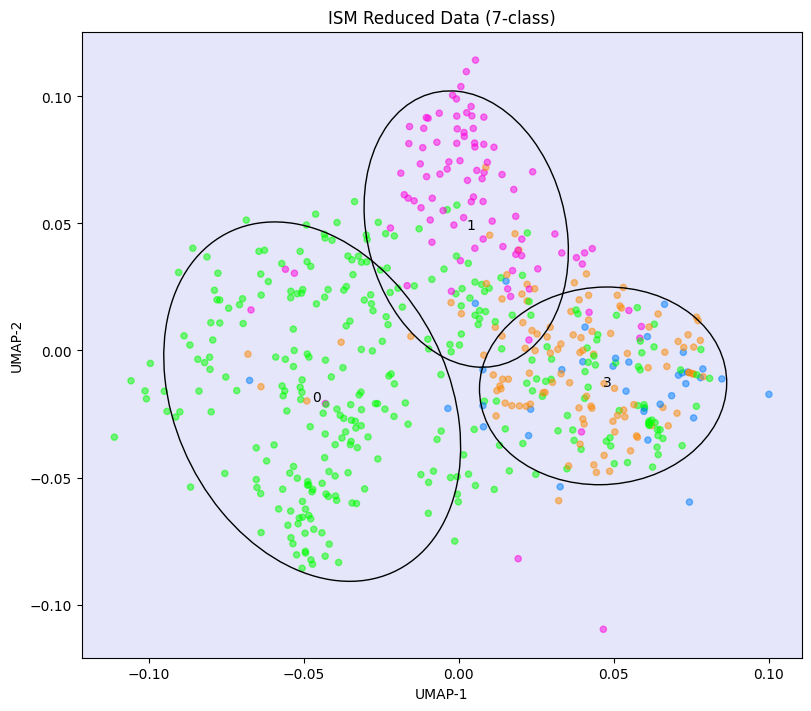

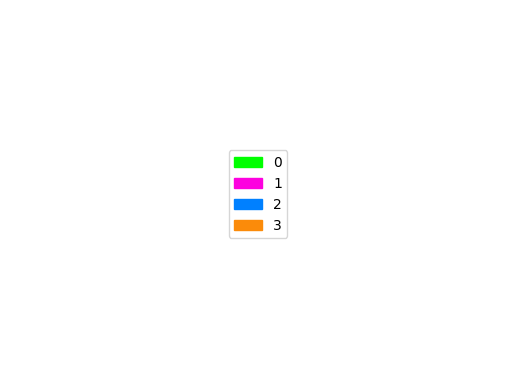

In [6]:
palette = distinctipy.get_colors(4)
cmap = ListedColormap(palette)

list_cell_types = [str(num) for num in range(4)]

patches = []
for code in range(4):
    patches.append(mpatches.Patch(color=palette[code], label=list_cell_types[code]))
    
# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, cell_label, ax, n_std=2, facecolor='none', **kwargs):
    # Create a plot of the covariance confidence ellipse of `x` and `y`
    # Adapted from [1](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
    
    # Calculate the covariance matrix and the Pearson correlation coefficient
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Use a special case to obtain the eigenvalues of the covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    # Create the ellipse object
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    # Scale and translate the ellipse according to the mean and standard deviation of the data
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    
    # Annotate centroid
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    ax.annotate(cell_label, xy=(x_mean, y_mean))

    # Add the ellipse to the axes
    ax.add_patch(ellipse)
    return x_mean, y_mean

# define a function to plot scatter with clusters and confidence ellipses
def plot_scatter(x, y, title=None, k=None, ax=None, skip_ellipse=[], face_color='lavender', **kwargs):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.c_[x, y])
    # Get the cluster labels and centroids
    labels = kmeans.labels_  # Get cluster labels
    labels_matched = np.empty_like(labels)
    unique_labels = np.unique(labels)
    truth_label = np.zeros(len(unique_labels))

    # For each cluster label...
    for l in unique_labels:
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((labels==l)*(list_cell_codes==t)) for t in np.unique(list_cell_codes)]
        truth_label[l] = np.unique(list_cell_codes)[np.argmax(match_nums)]
        labels_matched[labels==l] = truth_label[l]

    ax.scatter(x, y, c=list_cell_codes, cmap=cmap, alpha=0.5, s=20)
    ax.set_title(title)
    # ax.set_xlabel("MDS-1")
    # ax.set_ylabel("MDS-2")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_facecolor(face_color)

    p1 = np.zeros(k)
    p2 = np.zeros(k)
    unique_labels_matched = np.unique(labels_matched)
    xy_mean = np.zeros((len(unique_labels),2))    
    mean_intra_distance = np.zeros(len(unique_labels))
    mean_inter_distance = np.zeros(len(unique_labels))
    flag = np.zeros(len(unique_labels))

    for l in unique_labels_matched:
        indices = np.where(truth_label == l)[0]
        if indices.shape[0] > 1:
            # calculate mean distance inter-clusters pointing to same class
            xy_mean2 = np.zeros((indices.shape[0],2))
            for l2 in range(len(indices)):
                xy_mean2[l2,0] = np.mean(x[labels == indices[l2]])
                xy_mean2[l2,1] = np.mean(y[labels == indices[l2]])
                xy_intra = np.column_stack((x[labels == indices[l2]], y[labels == indices[l2]]))
                D = distance_matrix(xy_intra, xy_intra)
                mean_intra_distance[l] += np.mean(D[D>0])
                    
            D = distance_matrix(xy_mean2, xy_mean2)
            mean_inter_distance[l] = np.mean(D[D>0])
            if mean_inter_distance[l] / mean_intra_distance[l] > 2.5:
                flag[l] = 1

    n_matched_cell_types = 0
    
    for l in np.unique(labels_matched):
        if not flag[l]:
            p1[l] = np.sum(labels_matched[labels_matched==l] == list_cell_codes[labels_matched==l])
            p2[l] = p1[l] / np.sum(list_cell_codes == l)
            p1[l] /=  np.sum(labels_matched == l)
            # if p1[l] > .5 and p2[l] > .5:
            if p2[l] > 0.5:
                n_matched_cell_types += 1
                xy_mean[l,0], xy_mean[l,1] = confidence_ellipse(x[labels_matched == l], y[labels_matched == l], list_cell_types[l], ax, n_std=2, edgecolor='black')
            else:
                p1[l] = 0
                p2[l] = 0
        else:
            xy_mean[l,0] = 0
            xy_mean[l,1] = 0
    
    print(n_matched_cell_types, round(np.sum(p1*p2),2))
    print(round(adjusted_rand_score(labels_matched, list_cell_codes),4)) 
    print(round(normalized_mutual_info_score(list_cell_codes, labels_matched),4)) 

# fig, ax = plt.subplots(3, 2, figsize=(14, 18), constrained_layout=True)
fig, ax = plt.subplots(figsize=(8, 7), constrained_layout=True)

face_color = 'lavender'
k=4

plot_scatter(w4_ism_mds[:, 0], w4_ism_mds[:, 1], title="ISM Reduced Data (7-class)", k=k, ax=ax)
plt.show

# Add the legend to a new figure
fig2, ax2 = plt.subplots()
ax2.legend(handles=patches, loc='center')
plt.gca().set_axis_off()
ax2.set_facecolor(face_color)
plt.show

[[-0.33152021  0.55397862 -0.48779376  0.544567  ]
 [ 0.8071263  -0.14864215 -0.61447458 -0.00581601]
 [-0.16022179 -0.2323492   0.47741036 -0.0348658 ]
 [-0.55662316 -0.03536921  0.67013325 -0.41001331]]


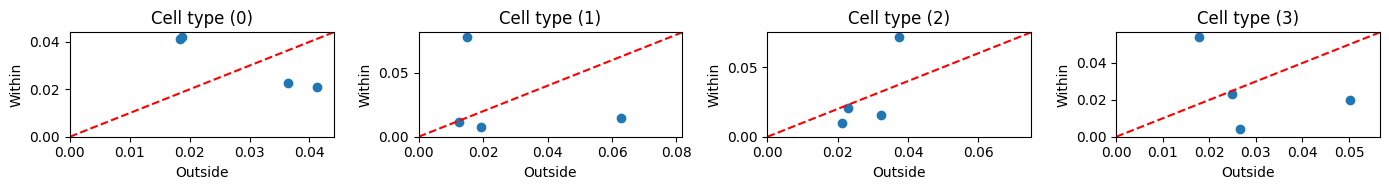

In [7]:
specificity, df_means_within_outside = specificity_score(df_w4_ism)
print(specificity)
specificity_plot(df_means_within_outside)